In [42]:
import climpy.aeronet_utils as aeronet
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import climpy.grid_utils as grid
import netCDF4
import climpy.wrf_utils as wrf_utils
from climpy.plotting_utils import save_figure_bundle, save_fig, get_JGR_full_page_width_inches
from scipy.constants import golden

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

## IMPORTANT
First you have to set the path to the Aeronet data
If you don't have it yet, go to https://aeronet.gsfc.nasa.gov/
and click "Download All Sites" under Optical Depth or Inversion tabs. Extract them and specify this path below.

In [2]:
# Normally, I run scripts locally and on supercomputers and often root file path is different.
# To solve this problem I have special routine to deduce the correct environment.
from libs.file_path_utils import get_root_storage_path_on_hpc
aeronet.DATA_FILE_PATH_ROOT = get_root_storage_path_on_hpc() + '/Data/NASA/Aeronet/'

# You can simply copy-paste YOUR path in the next line
# aeronet.DATA_FILE_PATH_ROOT = os.path.expanduser('~') + '/Data/NASA/Aeronet/'



# you'll notice this paramters often
level = 15  # set the aeronet level 1.5 or 2.0
res = aeronet.DAILY  # set the temporal resolution, all points, daily, monthly
inv = False  # choose the product, direct ovservations (AOD) or inversion (INV)

## Basics
Get the AOD and plot it

Text(0.5, 1.0, 'Daily optical depth at Solar_Village')

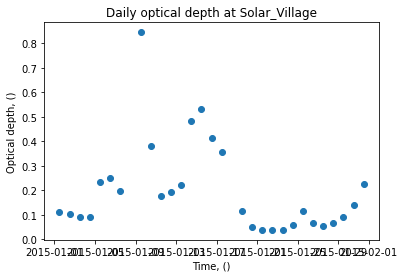

In [6]:
station='Solar_Village'  # Note the the wildcards
# use aux function to return ValueObject with the given diagnostic
# you can also apply time filter
time_range = (dt.datetime(2015, 1, 1), dt.datetime(2015, 2, 1))
aod_vo = aeronet.get_aod_diag('*{}*'.format(station), 'AOD_500nm', level=15, res=aeronet.DAILY,
                                      time_range=time_range)
# plot it
plt.figure()
plt.plot(aod_vo['time'], aod_vo['data'], 'o')
plt.xlabel('Time, ()')
plt.ylabel('Optical depth, ()')
plt.title('Daily optical depth at {}'.format(station))

Similarly, the size distribution dV/dlnr from the INV product can be read and plotted.
To normalize SD pass additional sd_normalization_raduis parameter.

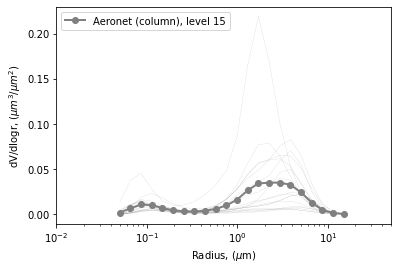

In [8]:
vo = aeronet.get_size_distribution('*{}*'.format(station), level=15, res=aeronet.DAILY,
                                   # sd_normalization_raduis=0.5,  # will normalize to 1 at 0.5 micron
                                      time_range=time_range)

plt.figure()
#plot individual SDs
plt.plot(vo['radii'], np.transpose(vo['data']), '-', color='gray', lw=0.1)
# and the mean
plt.plot(vo['radii'], np.mean(vo['data'], axis=0), '-o', color='gray', lw=2, label='Aeronet (column), level {}'.format(level))

plt.xscale('log')
plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
plt.xlabel('Radius, ($\mu $m)')
plt.ylabel('dV/dlogr, ($\mu m^3$/$\mu m^2$)')
plt.legend()


# Example: validation of WRF-Chem AOD

Suppose that you have a GCM model simulation and you want to validate simulated AOD or size distribution.
In this example I will use WRF-Chem. Since I can't upload NetCDF file (on github), some of the code will be commented out, but you should be able to adopt it easily.

In [20]:
# define time span and domain manually
domain = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])  # This is MENA region (Middle East and North Africa)
time_range = (dt.datetime(2015, 1, 1), dt.datetime(2015, 2, 1))

# or use your WRF sim instead, you have to put YOUR path here
wrf_file_path = get_root_storage_path_on_hpc() + '/Data/AirQuality/AQABA/chem_106/output/wrfout_d01_2017-07-20_00:00:00'
nc = netCDF4.Dataset(wrf_file_path)
lon = nc['XLONG'][0]  # my grid is stationary in time
lat = nc['XLAT'][0]  # sample it at time index 0
domain = Polygon([(np.min(lon), np.min(lat)), (np.min(lon), np.max(lat)), (np.max(lon), np.max(lat)), (np.max(lon), np.min(lat))])  # This is MENA region (Middle East and North Africa)
wrf_time = wrf_utils.generate_netcdf_uniform_time_data(nc.variables['Times'])
time_range = (wrf_time.min(), wrf_time.max())

In [22]:
# filter stations that cover simulation period and are within your regional model domain
stations = aeronet.filter_available_stations(domain, time_range, aod_level=20)

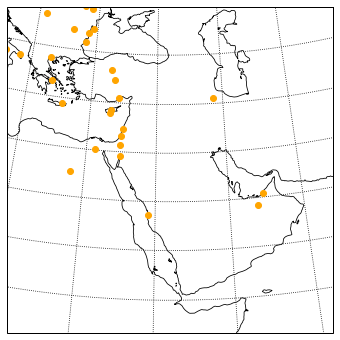

In [24]:
# and plot the map of the domain and Aeronet stations
fig, ax = wrf_utils.plot_domain(nc)
import cartopy.crs as crs
ax.plot(stations['Longitude(decimal_degrees)'], stations['Latitude(decimal_degrees)'],
         color='orange', marker='o', linewidth=0,
         transform=crs.PlateCarree(),)

First, lets compare only 1 station from the list

In [27]:
station = stations.iloc[0]


def get_wrf_aod_at_aeronet_location(station):
    yx_tuple, lon_p, lat_p, distance_error = grid.find_closest_grid_point(lon, lat,
                                                                          station['Longitude(decimal_degrees)'],
                                                                          station['Latitude(decimal_degrees)'])
    # check that station is not too far, i.e. distance_error < some value, say 0.1
    if distance_error > 1:
        print('station {} is too far'.format(station['Site_Name']))
        return None
    # read OD profile (t, z, y, x)
    AOD = nc.variables['TAUAER3'][:, :, yx_tuple[0], yx_tuple[1]]
    column_AOD = np.sum(AOD, axis=1)

    vo = {}
    vo['time'] = wrf_time
    vo['data'] = column_AOD

    return vo


# keys to access dictionary
aeronet_var_key = 'AOD_500nm'
wrf_var_key = 'AOD_600nm'

# prepare data first
wrf_vo = get_wrf_aod_at_aeronet_location(station)
aeronet_vo = aeronet.get_aod_diag('*{}*'.format(station['Site_Name']), aeronet_var_key, 15, aeronet.ALL_POINTS,
                                  time_range=time_range)

NameError: name 'aod_level' is not defined

Plot the time series comparison

Text(0.5, 1.0, 'Column AOD at SEDE_BOKER')

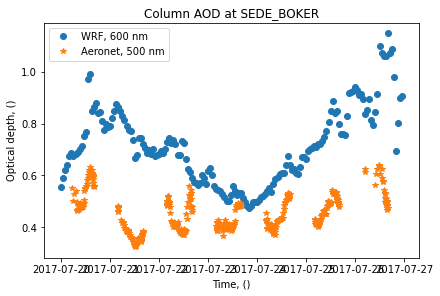

In [30]:
plt.figure(constrained_layout=True)
plt.plot(wrf_vo['time'], wrf_vo['data'], 'o', label='WRF, 600 nm')
plt.plot(aeronet_vo['time'], aeronet_vo['data'], '*', label='Aeronet, 500 nm')
plt.ylabel('Optical depth, ()')
plt.xlabel('Time, ()')
plt.legend()
plt.title('Column AOD at {}'.format(station['Site_Name']))

## Scatter plot
Here we bring the data to the same temporal resulution, in this case daily ('D').
Similarly, you could do monthly or hourly. Note, that Aeronet source data is ALL_POINTS for illustration purpose.
If you are going to compare daily data with the model, read Aeronet at aeronet.DAILY resolution, it will work faster.

Text(0, 0.5, 'Model')

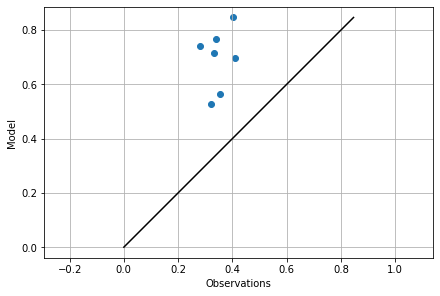

In [37]:
# bring data to the same resolution
df = pd.DataFrame(data=wrf_vo['data'], index=wrf_vo['time'], columns=[wrf_var_key])
wrf_df = df.resample('D').mean()
df = pd.DataFrame(data=aeronet_vo['data'], index=aeronet_vo['time'], columns=[aeronet_var_key])
aeronet_df = df.resample('D').mean()

# make sure that values are compared at the same time
d1, model_ind, obs_ind = np.intersect1d(wrf_df.index, aeronet_df.index, return_indices=True)

# plot
plt.figure(constrained_layout=True)
plt.grid()
plt.axis('equal')
plt.scatter(aeronet_df.iloc[obs_ind], wrf_df.iloc[model_ind])
# y=x line
global_max = np.max([wrf_df.iloc[model_ind].max(), aeronet_df.iloc[obs_ind].max()])
plt.plot([0, global_max], [0, global_max], 'k-')
plt.xlabel('Observations')
plt.ylabel('Model')

Now we can compare all the station.

WARNING: it can take some time to read the WRF data.
To accelerate things:
 1. switch to NetCDF4 (instead of 3)
 2. or do the post-processing and prepare column AOD in the separate file. See the wrf_pp.py example.

In [33]:
# Process all stations, prepare data first

wrf_list = []
aeronet_list = []
for index, station in stations.iterrows():
    print('Processing {}'.format(station['Site_Name']))
    wrf_vo = get_wrf_aod_at_aeronet_location(station)
    aeronet_vo = aeronet.get_aod_diag('*{}*'.format(station['Site_Name']), aeronet_var_key, 15, aeronet.ALL_POINTS,
                                      time_range=time_range)

    wrf_list.append(wrf_vo)
    aeronet_list.append(aeronet_vo)

Processing SEDE_BOKER
Processing IMAA_Potenza
Processing Moldova
Processing IMS-METU-ERDEMLI
Processing Lecce_University
Processing ATHENS-NOA
Processing Messina
Processing Thessaloniki
Processing Mezaira
Processing Karachi
station Karachi is too far
Processing Eilat
Processing Eforie
Processing IASBS
Processing TUBITAK_UZAY_Ankara
Processing CUT-TEPAK
Processing Dushanbe
station Dushanbe is too far
Processing Gloria
Processing Timisoara
Processing Masdar_Institute
Processing Magurele_Inoe
Processing Cairo_EMA_2
Processing KAUST_Campus
Processing Iasi_LOASL
Processing Galata_Platform
Processing El_Farafra
Processing Finokalia-FKL
Processing Tuz_Golu_3
Processing AgiaMarina_Xyliatou
Processing Weizmann_Institute
Processing Technion_Haifa_IL


In [ ]:
# define were you want to save figures
#pics_output_folder = get_pictures_root_folder() + '/Papers/AirQuality/AQABA/{}/'.format(sim_version)
pics_output_folder = os.path.expanduser('~') + '/Papers/AirQuality/AQABA/{}/'.format('tutorial')

Time series plot for each site individually

TypeError: 'NoneType' object is not subscriptable

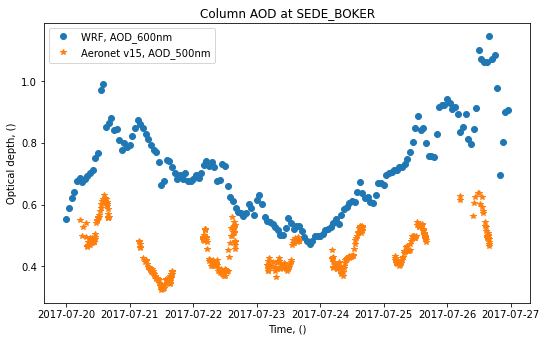

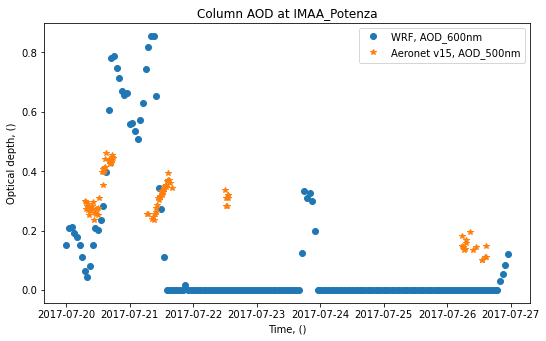

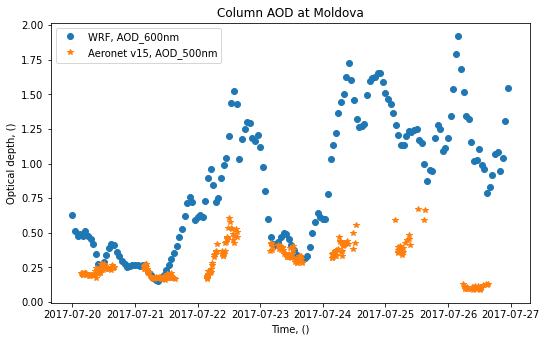

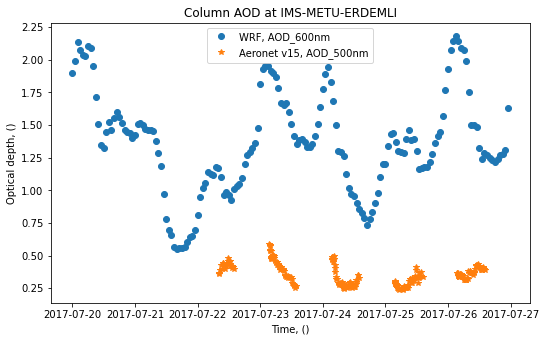

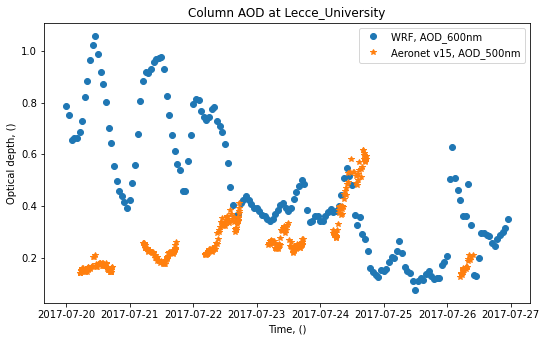

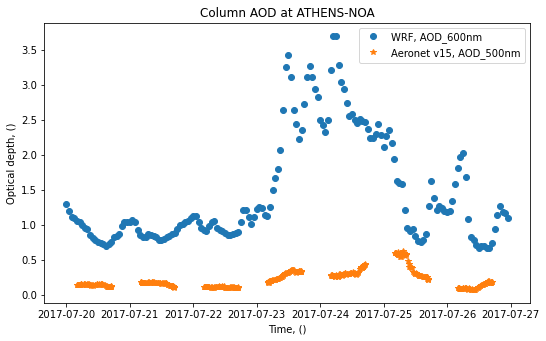

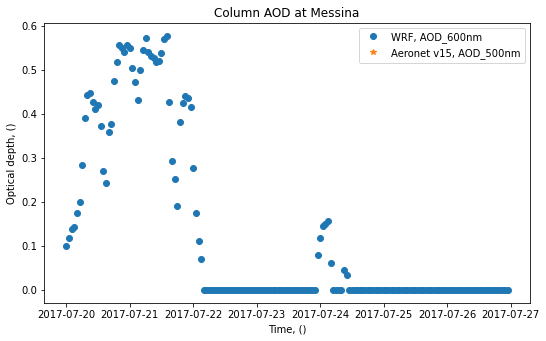

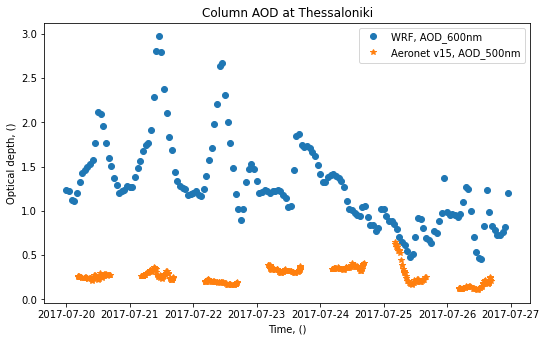

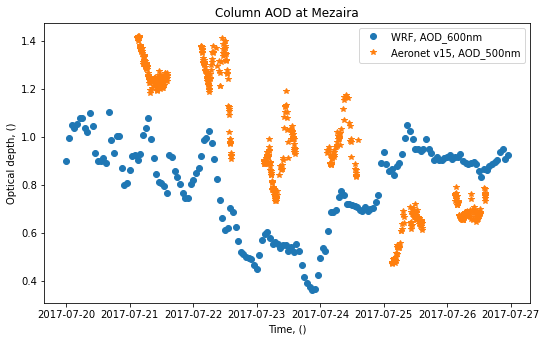

<Figure size 538.583x332.862 with 0 Axes>

In [45]:
for wrf_vo, aeronet_vo, dummy in zip(wrf_list, aeronet_list, stations.iterrows()):
    station = dummy[1]

    fig = plt.figure(constrained_layout=True, figsize=(get_JGR_full_page_width_inches(), get_JGR_full_page_width_inches()/golden))
    plt.plot(wrf_vo['time'], wrf_vo['data'], 'o', label='WRF, {}'.format(wrf_var_key))
    plt.plot(aeronet_vo['time'], aeronet_vo['data'], '*', label='Aeronet v{}, {}'.format(level, aeronet_var_key))
    plt.ylabel('Optical depth, ()')
    plt.xlabel('Time, ()')
    plt.legend()
    plt.title('Column AOD at {}'.format(station['Site_Name']))

    #save_fig(pics_output_folder + '/aeronet/by_site/', 'WRF-Aeronet AOD, {}.svg'.format(station['Site_Name']))
    #plt.close(fig)

# Next, do the scatter plot

TypeError: 'NoneType' object is not subscriptable

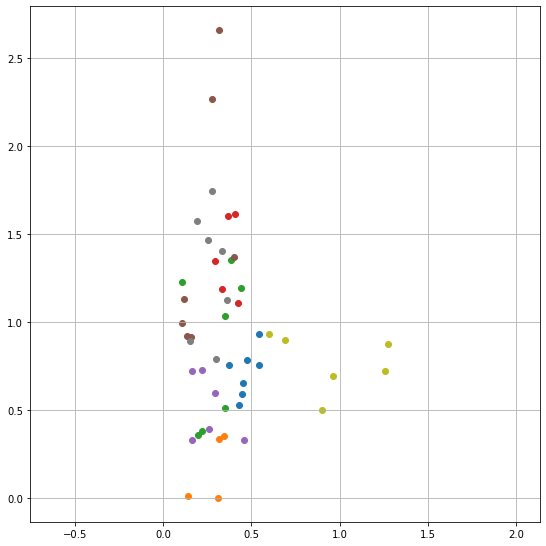

In [46]:
plt.figure(constrained_layout=True, figsize=(get_JGR_full_page_width_inches(), get_JGR_full_page_width_inches()))
plt.grid()
plt.axis('equal')

for wrf_vo, aeronet_vo, dummy in zip(wrf_list, aeronet_list, stations.iterrows()):
    station = dummy[1]
    # Do the scatter plot, bring data to the same resolution
    df = pd.DataFrame(data=wrf_vo['data'], index=wrf_vo['time'], columns=[wrf_var_key])
    wrf_df = df.resample('D').mean()
    df = pd.DataFrame(data=aeronet_vo['data'], index=aeronet_vo['time'], columns=[aeronet_var_key])
    aeronet_df = df.resample('D').mean()

    # make sure that values are compared at the same time
    d1, model_ind, obs_ind = np.intersect1d(wrf_df.index, aeronet_df.index, return_indices=True)
    plt.scatter(aeronet_df.iloc[obs_ind], wrf_df.iloc[model_ind], label=station['Site_Name'])

plt.legend()
# y=x line
#global_max = np.max([wrf_df.iloc[model_ind].max(), aeronet_df.iloc[obs_ind].max()])
global_max = 3
plt.plot([0, global_max], [0, global_max], 'k-')

plt.xlabel('Observations')
plt.ylabel('Model')
plt.title('Aeronet v{} {}, WRF {}'.format(level, aeronet_var_key, wrf_var_key))

#save_figure_bundle(pics_output_folder + '/aeronet/', '_ WRF-Aeronet AOD scatter, all stations')

# DONE

# PS: Generic tools
The examples above are simply the wrappers around more generic utils (with decorators). They extract data from pandas object and put it into ValueObject (dictionary).

If you need more flexibility, you can use pandas directly, but you'll have to do each step manually.

In [ ]:
# build the file path to the station
fp = aeronet.get_station_file_path('*KAUST*', level=20, res=aeronet.DAILY, inv=False)
# read all fields into pandas
df = aeronet.read_aeronet(fp)
# pick a diag from the list of available
var_key = df.columns[3]
# or assign it by hand if you know the label
var_key = 'AOD_1020nm'
# plot it
df[var_key].plot()

## Listing stations

In [ ]:
# list all Aeronet stations (with meta-data)
all_stations = aeronet.get_all_stations_and_coordinates()

# or list stations, that have observation during specific time interval (without meta-data)
prelim_stations = aeronet.get_available_stations(time_range, aod_level=15)

## Alternative to getting list of stations from the WEB
Instead of getting list of stations from the WEB, you can search in the local files only. However, it is much slower and not recommend.

In [ ]:
# First, lets get the list of all Aeronet stations
file_paths = aeronet.get_stations_file_path(aeronet.ALL_STATIONS, level=15, res=aeronet.ALL_POINTS, inv=False)


def spatial_filter(file_path):
    """
    Example of the spatial filter.
    Checks if the station is inside the polygon.
    :param file_path:
    :return:
    """
    df = aeronet.read_aeronet(file_path, only_head=True)
    point = Point(df['Site_Longitude(Degrees)'].iloc[0], df['Site_Latitude(Degrees)'].iloc[0])
    # MENA region
    polygon = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])
    return polygon.contains(point)


def spatial_and_temporal_filter(file_path):
    """
    Example of the spatial and temporal filter.
    Checks if the station is inside the polygon and if time coverage is appropriate.
    :param file_path:
    :return:
    """
    df = aeronet.read_aeronet(file_path, only_head=True)
    point = Point(df['Site_Longitude(Degrees)'].iloc[0], df['Site_Latitude(Degrees)'].iloc[0])
    # MENA region
    polygon = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])
    loc_flag = polygon.contains(point)
    time_flag = df.index[0] <= dt.datetime(2019, 1, 1)
    # TODO: we can also read last record and compare the right time interval as well

    return loc_flag and time_flag


# filter the stations inside the polygon (model domain bounds)
fps = aeronet.filter_stations(file_paths, spatial_filter)

# or add additional time filter (for example, simulations temporal extent)
fps = aeronet.filter_stations(file_paths, spatial_and_temporal_filter)